In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import os
import math

In [2]:
DATASET_PATH = "./Dataset/Logos"
images = []

In [3]:
for idx, filename in enumerate(os.listdir(DATASET_PATH)):
    img = tf.keras.preprocessing.image.load_img(os.path.join(DATASET_PATH, filename), target_size=(100, 100))
    img = tf.keras.preprocessing.image.img_to_array(img)
    images.append(img)

    if idx > 500:
        break


In [4]:
images = np.asarray(images) / 255.

test_len = 10

In [5]:
x_train = images[:-test_len]
x_test = images[test_len:]

In [6]:
BATCH_SIZE = 20
IMAGE_ORIGINAL_SHAPE = x_train.shape[1:]
IMAGE_SIZE = IMAGE_ORIGINAL_SHAPE[0] * IMAGE_ORIGINAL_SHAPE[1] * IMAGE_ORIGINAL_SHAPE[2]
HIDDEN_DIM = 512
LATENT_DIM = 32
MAX_EPOCHS = 30
LEARNING_RATE = 0.0001

In [7]:
class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)

        h_dim = dim[0]
        z_dim = dim[1]

        self.fc1 = tf.keras.layers.Dense(h_dim, activation = tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)
        self.fc4 = tf.keras.layers.Dense(h_dim)
        self.fc5 = tf.keras.layers.Dense(IMAGE_SIZE)

        self.encoder_batch_norm = tf.keras.layers.BatchNormalization()
        self.decoder_batch_norm = tf.keras.layers.BatchNormalization()

    def encode(self, x):
        x = self.encoder_batch_norm(x)
        h = self.fc1(x)
        return self.fc2(h), self.fc3(h)

    def decode_logits(self,z):
        h = self.fc4(z)
        h = self.fc5(h)
        return self.decoder_batch_norm(h)

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)
        return mu + eps * std

    def call(self, input, training=None, mask=None):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        x_recon_logits = self.decode_logits(z)
    
        return x_recon_logits, mu, log_var


In [8]:
class ReparameterizationLayer(tf.keras.layers.Lambda):
    def __init__(self, *args, **kwargs):
        super(ReparameterizationLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        m, log = inputs
        return m

In [9]:
def reparameterize_functional(m, log):
    def reparameterize(args):
        m, log = args
        std = tf.exp(0.5 * log)
        eps = tf.random.normal(shape = tf.shape(std))
        return m + eps * std

    z = ReparameterizationLayer(reparameterize, name="reparameterization_layer")([m, log])
    return z

In [10]:
def build_model():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE,))
    x = tf.keras.layers.BatchNormalization()(inputs)

    latent_space = tf.keras.layers.Dense(HIDDEN_DIM, name='latent_space')(x)
    z_mean = tf.keras.layers.Dense(LATENT_DIM, name='z_mean')(latent_space)
    z_log_var = tf.keras.layers.Dense(LATENT_DIM, name='z_log_var')(latent_space)
    z_out = reparameterize_functional(z_mean, z_log_var)
    x = tf.keras.layers.Dense(HIDDEN_DIM, activation='relu')(z_out)
    x = tf.keras.layers.Dense(IMAGE_SIZE)(x)
    outputs = tf.keras.layers.BatchNormalization()(x)

    return tf.keras.models.Model(inputs, outputs, name='vae')

In [11]:
model_plotting = build_model()
tf.keras.utils.plot_model(model_plotting, to_file='plot.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [12]:
model = VAE([HIDDEN_DIM, LATENT_DIM])
model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE))
print(model.summary())

c:\Users\wsusa\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'vae', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [13]:
optimizers = tf.keras.optimizers.Adam(LEARNING_RATE)

dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE * 5).batch(batch_size=BATCH_SIZE)

In [14]:
loss_history = []
kl_dv_history = []

num_batches = x_train.shape[0] // BATCH_SIZE

for epoch in range(25):
    for x in dataset:
        x = tf.reshape(x, [-1, IMAGE_SIZE])

        with tf.GradientTape() as tape:
            x_reconstruction_logits, mu, log_var = model(x)

            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits = x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss / BATCH_SIZE)

            kl_div = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            loss = tf.reduce_mean(reconstruction_loss + kl_div)
        
        gradients = tape.gradient(loss, model.trainable_variables)

        for g in gradients:
            tf.clip_by_norm(g, 15)
        
        optimizers.apply_gradients(zip(gradients, model.trainable_variables))
    
    loss_history.append(loss)
    kl_dv_history.append(kl_div)
    print(f"Epoch: [{epoch+1}/25] | Reconstruction Loss: {float(reconstruction_loss):.2f} | KLDiV: {float(loss):.2f} | Loss: {float(loss):.2f}")

Epoch: [1/25] | Reconstruction Loss: 6121.00 | KLDiV: 7100.28 | Loss: 7100.28
Epoch: [2/25] | Reconstruction Loss: 7389.80 | KLDiV: 8314.72 | Loss: 8314.72
Epoch: [3/25] | Reconstruction Loss: 4653.85 | KLDiV: 5059.10 | Loss: 5059.10
Epoch: [4/25] | Reconstruction Loss: 3693.58 | KLDiV: 4078.80 | Loss: 4078.80
Epoch: [5/25] | Reconstruction Loss: 3950.73 | KLDiV: 4244.64 | Loss: 4244.64
Epoch: [6/25] | Reconstruction Loss: 2385.44 | KLDiV: 2675.75 | Loss: 2675.75
Epoch: [7/25] | Reconstruction Loss: 5068.89 | KLDiV: 5265.60 | Loss: 5265.60
Epoch: [8/25] | Reconstruction Loss: 2467.66 | KLDiV: 2766.89 | Loss: 2766.89
Epoch: [9/25] | Reconstruction Loss: 3286.39 | KLDiV: 3542.99 | Loss: 3542.99
Epoch: [10/25] | Reconstruction Loss: 2511.64 | KLDiV: 2847.50 | Loss: 2847.50
Epoch: [11/25] | Reconstruction Loss: 2609.80 | KLDiV: 2898.20 | Loss: 2898.20
Epoch: [12/25] | Reconstruction Loss: 2753.19 | KLDiV: 3075.67 | Loss: 3075.67
Epoch: [13/25] | Reconstruction Loss: 3795.11 | KLDiV: 4070.9

In [15]:
def get_out_from_z(z):
    out = model.decode(z)
    out = tf.reshape(out, (-1, IMAGE_ORIGINAL_SHAPE[0], IMAGE_ORIGINAL_SHAPE[1], IMAGE_ORIGINAL_SHAPE[2]))
    return out

In [16]:
mu, log_var = model.encode(x_test.reshape(-1, IMAGE_SIZE))
z = model.reparameterize(mu, log_var)
out = get_out_from_z(z)

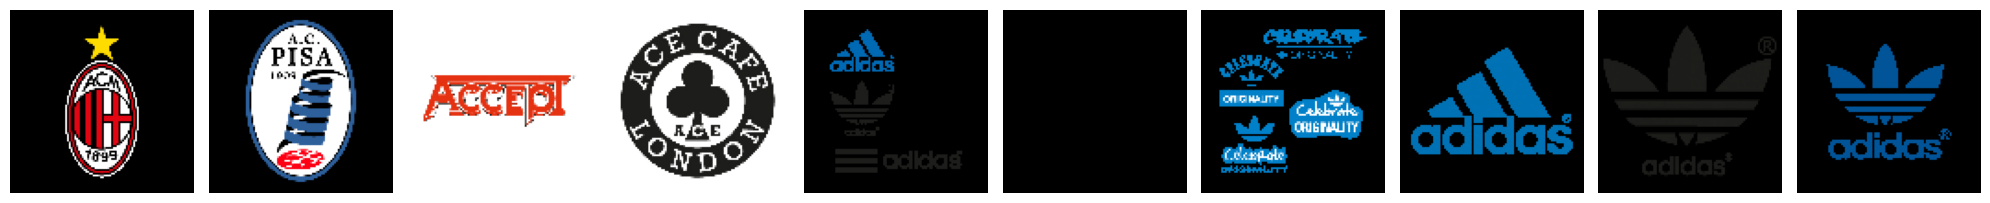

In [17]:
number = 10
plt.figure(figsize=(20, 8))
for idx in range(number):
    ax = plt.subplot(2, number, idx+1)
    plt.imshow(x_test[idx].reshape(IMAGE_ORIGINAL_SHAPE), cmap='gray')
    plt.axis(False)

plt.tight_layout()
plt.show()

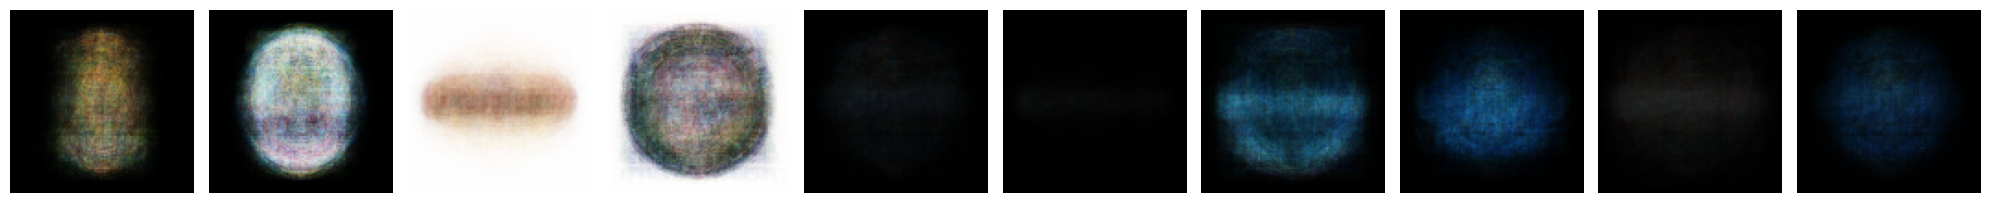

In [18]:
plt.figure(figsize=(20, 8))
for idx in range(number):
    ax = plt.subplot(2, number, idx+1)
    plt.imshow(out[idx], cmap='gray')
    plt.axis(False)

plt.tight_layout()
plt.show()